# Cumulative distance of features (enhancers, ChIP peaks) to dysregulated genes

**Purpose:** Investigating whether proximity to enhancers or ChIP peaks, as measured by distance between gene to closest enhancer/peak are predictive of gene dysregulation in 1 day of dNipBL-depleted mESCs. 

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
import plotting_histogram_functions as pfn
import filter_gene_functions as flt

### Loading project: DE results table, annotating TSSes, merging average vst-normalized feature counts into results table

In [55]:
import importlib
importlib.reload(flt)

<module 'filter_gene_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/filter_gene_functions.py'>

In [56]:
# import gene data, cutoff=6, label DE status
day1_res_df = flt.load_tss_df()
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


# Cumulative Distance Plots

* Chen/Whyte Enhancers
* All ChIP peaks

In [58]:
dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'

chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
# whythe_reg = 'remapped_enhancers_Whyte_2013_mm9.bed.txt' <-- where is this?

enhancers = {'chen_s1' : dataset_folder+chen_s1,
             'wythe_super' : dataset_folder+whythe_super}

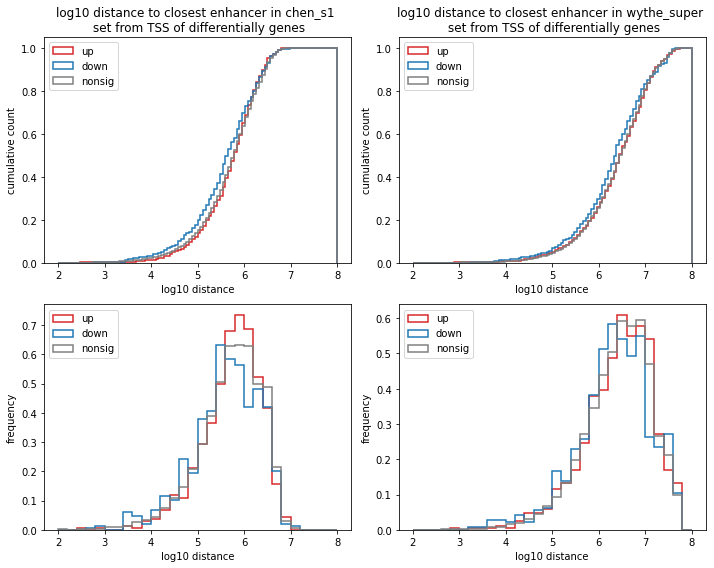

In [59]:
# Label distance to closest enhancer using annotated enhancer elements
for label, file in enhancers.items():
    peaks = flt.get_peak_bioframe(file)
    day1_res_df = flt.label_closest_peak(day1_res_df, peaks, label)

# Plot
fig, axs = plt.subplots(2,2, figsize=(10, 8))

for (enhancer_label, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):
    pfn.plot_distance_histogram(day1_res_df, 
                                 enhancer_label+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest enhancer in {} \n set from TSS of differentially genes'.format(enhancer_label))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                enhancer_label+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

In [60]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf = "CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed"
rad21 = "RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed"
nipbl = "Nipbl_112.175.197.114.177.196_peaks.xls.bed"
promoter = "H3K27ac_EA92-97_peaks.xls.bed"

chip_peaks_condition_dict = {'CTCF' : chip_folder+ctcf, 'RAD21' : chip_folder+rad21,
                           'NIPBL' : chip_folder+nipbl, 'H3K27ac' : chip_folder+promoter}

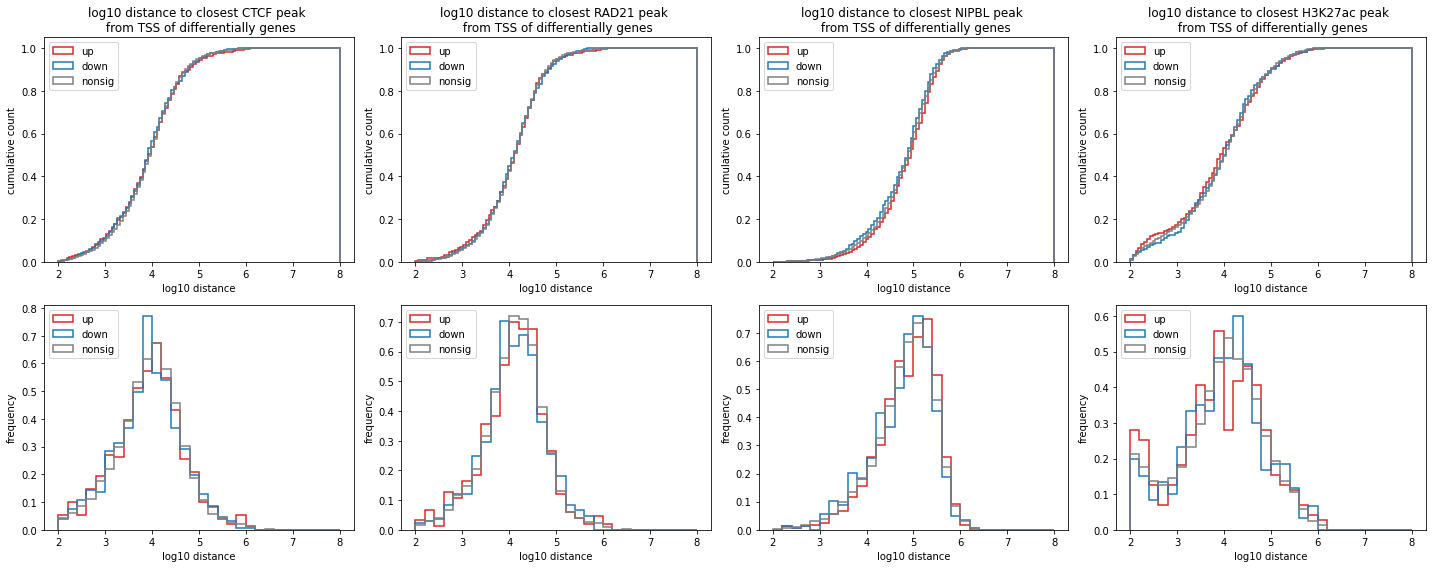

In [61]:
# Annotate df with distance to each peak
for (chip, file) in chip_peaks_condition_dict.items():
    peaks = flt.get_peak_bioframe(file)
    day1_res_df = flt.label_closest_peak(day1_res_df, peaks, chip)
    
fig, axs = plt.subplots(2, len(chip_peaks_condition_dict), figsize=(20, 8))

for (chip_name, file), axi in zip(chip_peaks_condition_dict.items(), np.arange(axs.shape[1])):
    pfn.plot_distance_histogram(day1_res_df, 
                                 chip_name+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest {} peak \n from TSS of differentially genes'.format(chip_name))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                chip_name+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

In [62]:
tss_df = flt.load_tss_df()
tss_df = flt.label_DE_status(tss_df)

### merging in gene body information
# todo: potentially re-factor as part of gtf reader
gene_bodies = pd.read_csv(
    "/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/gencode.vM23.primary_assembly.annotation.gtf",
    sep='\t', comment='#', names=[
    'chrom','db','type','start','end','score','strand','score2','metadata'])
gene_id = gene_bodies['metadata'].str.split('";',expand=True)[0].str.replace ('gene_id "','')                      
gene_bodies['gene_id'] = gene_id
gene_bodies.drop_duplicates('gene_id', inplace=True)

tss_df = tss_df.merge(gene_bodies[['chrom','start','end','strand','gene_id']],
                how='left', on='gene_id', suffixes=['','_gene'])

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


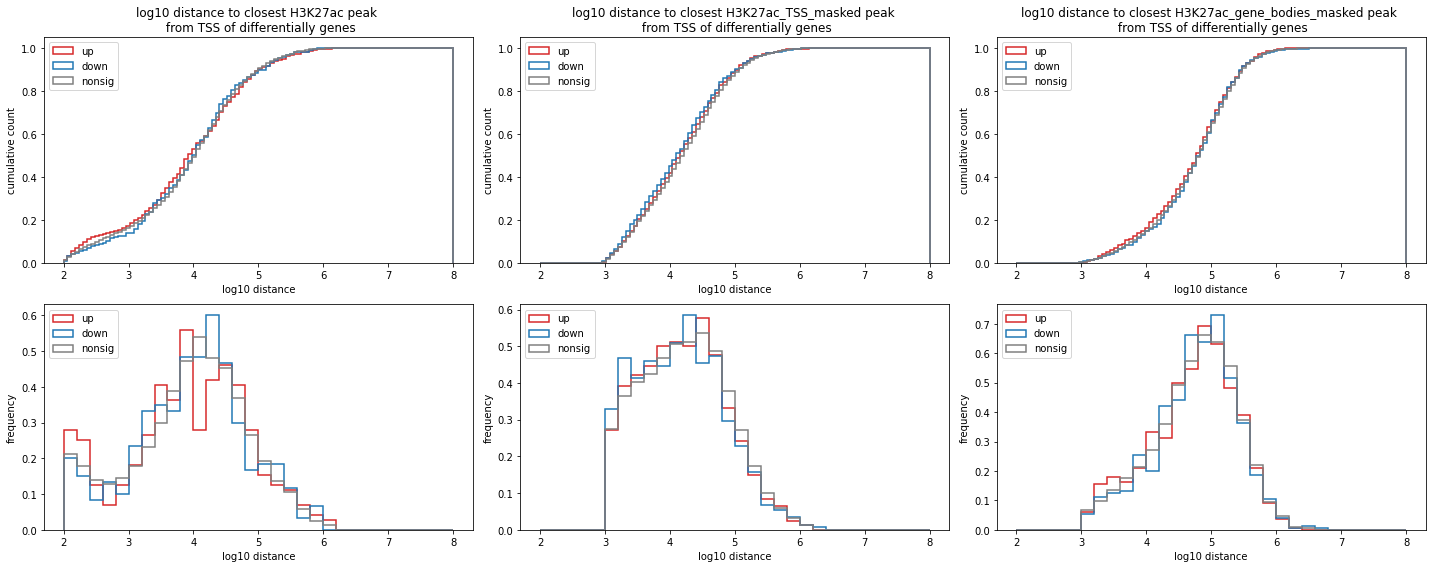

In [63]:
h3k_frames = {}
tss_window_size = 1000
extend_gene_bp = int(1e3)
file = chip_peaks_condition_dict['H3K27ac']

feature_df = flt.get_peak_bioframe(file)

h3k_frames['H3K27ac'] = feature_df
h3k_frames['H3K27ac_TSS_masked'] = flt.mask_tss_proximal_features( feature_df, 
                                                                  tss_df, 
                                                                  window_size=tss_window_size)
h3k_frames['H3K27ac_gene_bodies_masked'] = flt.mask_gene_body_features( feature_df, 
                                                                       tss_df, 
                                                                       extend_gene_bp = extend_gene_bp)

fig, axs = plt.subplots(2, len(h3k_frames), figsize=(20, 8))

for (feature_name, feature_df), axi in zip(h3k_frames.items(), np.arange(axs.shape[1])):
    
    tss_df = flt.label_closest_peak(tss_df, feature_df, feature_name)
    
    pfn.plot_distance_histogram(tss_df, 
                                 feature_name+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest {} peak \n from TSS of differentially genes'.format(feature_name))
    
    pfn.plot_distance_histogram(tss_df, 
                                feature_name+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

In [113]:
# load the bioframe
window=1000
feature_name = 'H3K27ac'
ctcf_frame = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])

tss_df_with_CTCF = split_by_proximal_feature(tss_df, ctcf_frame, window_size=window, contains_feature=True)
tss_df_mask_CTCF = split_by_proximal_feature(tss_df, ctcf_frame, window_size=window, contains_feature=False)

In [114]:
tss_df.shape, tss_df_with_CTCF.shape, tss_df_mask_CTCF.shape

((19349, 20), (3619, 20), (15730, 20))

(19349, 20) (1660, 20) (17689, 20)
(19349, 20) (1943, 20) (17406, 20)
(19349, 20) (3619, 20) (15730, 20)
(19349, 20) (10811, 20) (8538, 20)


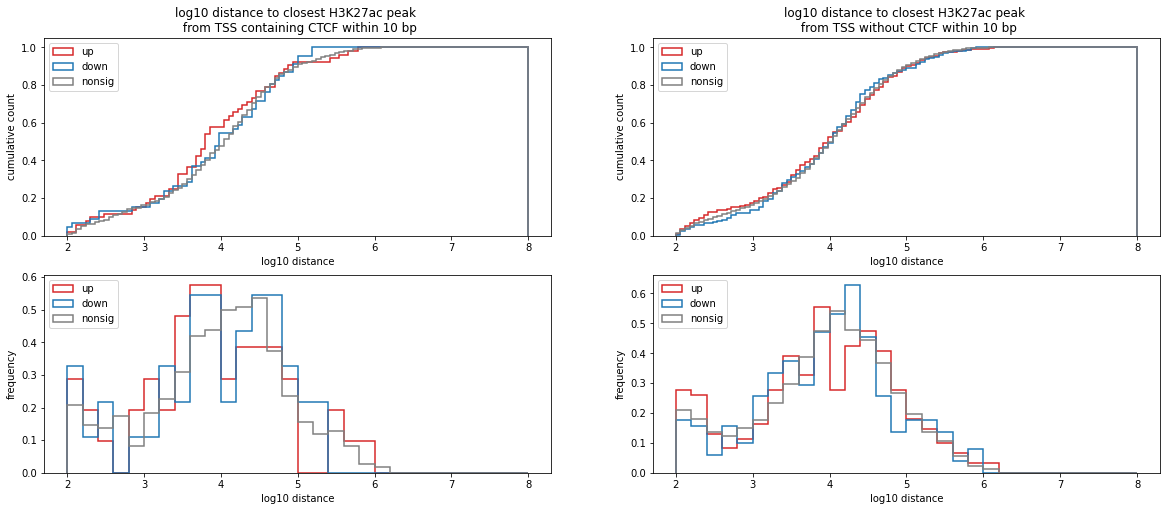

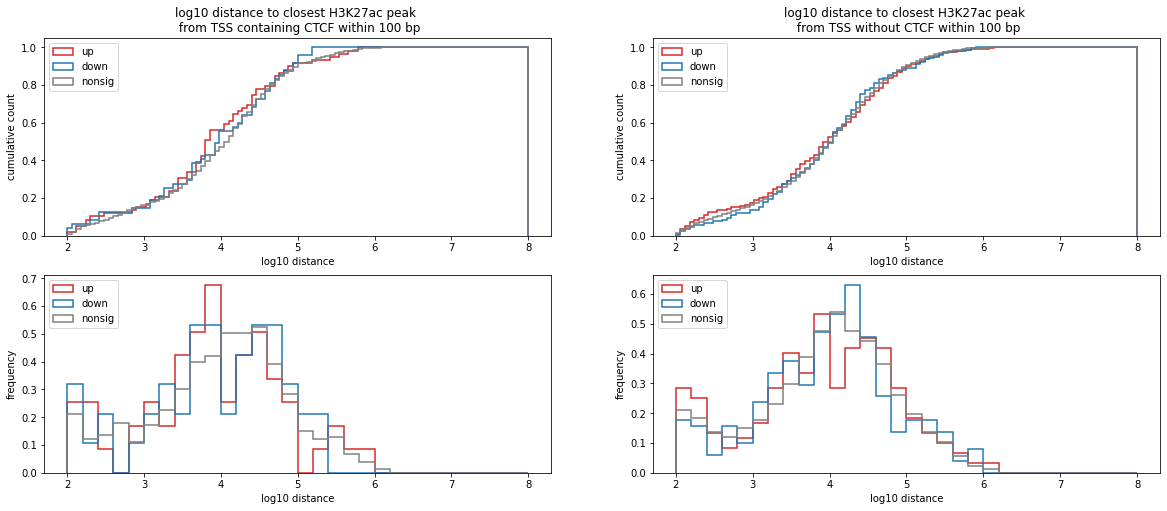

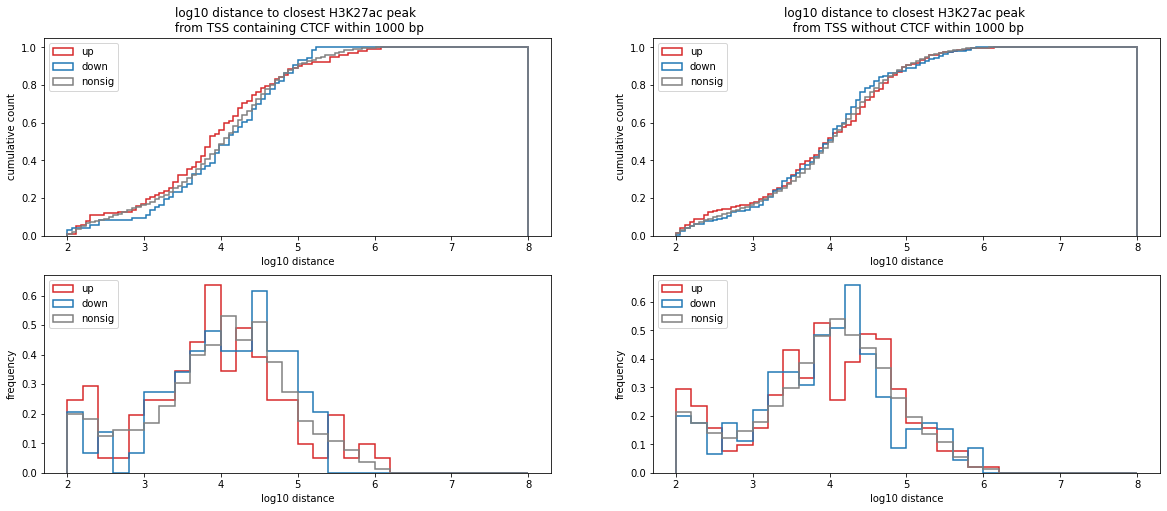

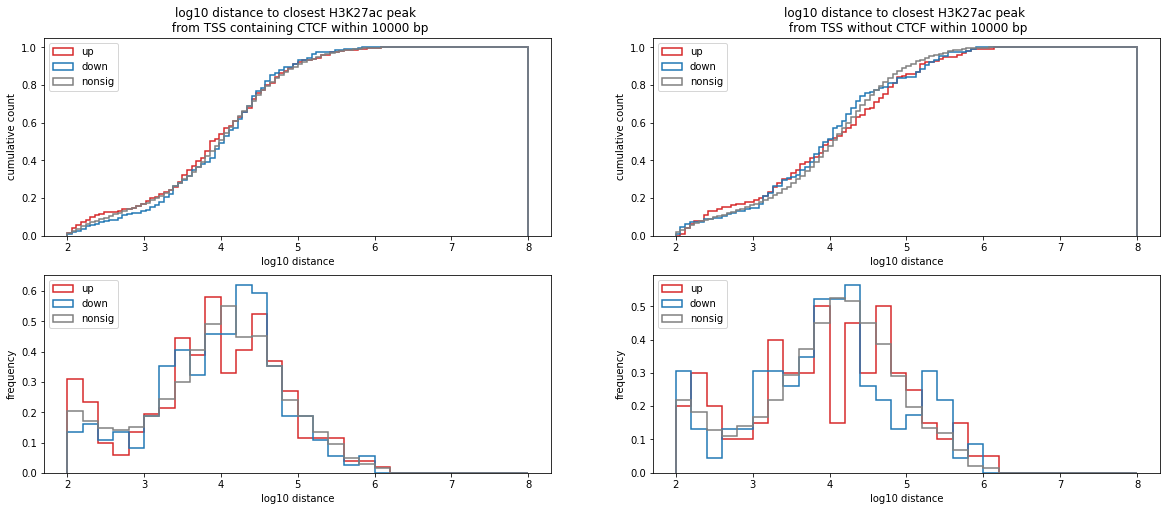

In [120]:
# load the bioframe
#window=100
feature_name = 'H3K27ac'
ctcf_frame = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])

for window in [10, 100, 1000, 10000]:
    tss_df_with_CTCF = split_by_proximal_feature(tss_df, ctcf_frame, window_size=window, contains_feature=True)
    tss_df_mask_CTCF = split_by_proximal_feature(tss_df, ctcf_frame, window_size=window, contains_feature=False)

    print(tss_df.shape, tss_df_with_CTCF.shape, tss_df_mask_CTCF.shape)

    fig, axs = plt.subplots(2, 2, figsize=(20, 8))

    pfn.plot_distance_histogram(tss_df_with_CTCF, 
                                 feature_name+'_distance', 
                                 ax=axs[0, 0],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest {} peak \n from TSS containing CTCF within {} bp'.format(feature_name, window))

    pfn.plot_distance_histogram(tss_df_with_CTCF, 
                                feature_name+'_distance', 
                                ax=axs[1, 0],
                                bins=30)

    pfn.plot_distance_histogram(tss_df_mask_CTCF, 
                                 feature_name+'_distance', 
                                 ax=axs[0, 1],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest {} peak \n from TSS without CTCF within {} bp'.format(feature_name, window))

    pfn.plot_distance_histogram(tss_df_mask_CTCF, 
                                feature_name+'_distance', 
                                ax=axs[1, 1],
                                bins=30)